# Machine Learning for Level Truncation in Open String Field Theory

Harold Erbin, Riccardo Finotello, Matej Kudrna, Martin Schnabl

---
---

## Abstract

In the framework of bosonic Open String Field Theory (OSFT), we consider several observables characterised by conformal weight and type, and the position of vacua in the potential for various values of truncated mass level. We focus on the prediction of the extrapolated value for the level-$\infty$ truncation using Machine Learning (ML) techniques.

In this notebook we compute the predictions of a double lump solution.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf

# set memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [3]:
import numpy as np

RAND = 123
np.random.seed(RAND)
tf.random.set_seed(RAND)

## Load the Dataset

We first load the dataset:

In [4]:
import pandas as pd
import re

df = pd.read_json('./data/data_sft_dlump_list.json')

# remove the init column
df = df.drop(columns=['init'])

# rename the columns
colrename = lambda s: re.sub(r'^([0-9]*)$', r'level_\1', s)
df        = df.rename(columns=colrename)

In [5]:
df.describe()

,weight,type,level_2,level_3,level_4,level_5,level_6,level_7,level_8,level_9,level_10,level_11,level_12,level_13,level_14,level_15,level_16,level_17,level_18
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,2.000000e+01,2.000000e+01,2.000000e+01
mean,1.715278,3.800000,-2.608983,-3.087235,12.360494,13.485368,-53.858729,-57.641226,258.016894,272.372603,-1172.908731,-1232.022585,5292.641517,5529.478551,-22317.746351,-23199.704152,8.566285e+04,8.869707e+04,-3.006011e+05
std,2.189245,0.615587,8.118042,9.802525,44.393799,48.702023,222.478514,238.231213,1116.816835,1180.256540,5174.917644,5439.189243,23531.629810,24590.746496,99564.849566,103507.763796,3.826730e+05,3.962378e+05,1.343627e+06
min,0.000000,2.000000,-33.620593,-40.373713,-1.734322,-1.825242,-997.122136,-1067.678440,-5.550577,-6.196558,-23157.212916,-24338.986279,-7.423880,-17.395405,-445320.847252,-462954.335124,-6.706599e+01,-6.704860e+01,-6.009038e+06
25%,0.090278,4.000000,-1.304863,-1.425327,0.000000,0.000000,-1.437197,-1.412107,-0.068770,-0.563107,-1.958771,-1.390445,-0.195941,-0.652932,-1.970593,-1.375239,-6.939012e-01,-1.802527e+00,-8.913318e+00
50%,1.000000,4.000000,0.000000,0.000000,0.011280,0.001635,0.000000,0.000000,0.010817,0.000460,0.000000,0.000272,1.219497,0.424945,0.000099,0.201399,1.182381e+00,4.360167e-01,2.550822e-01
75%,2.381944,4.000000,0.006879,0.341444,2.107497,2.043995,0.623679,0.639251,2.023673,2.021848,1.222807,1.711390,2.185291,2.014058,1.580704,2.010701,6.847626e+00,2.034738e+00,2.008174e+00
max,9.000000,4.000000,2.171332,2.499696,198.953725,218.118294,2.036695,2.032430,5001.157827,5284.903014,3.761426,9.229395,105266.161459,110002.605965,23.210856,23.159297,1.711459e+06,1.772124e+06,1.469126e+02


## Preprocessing

In order to compute accurate predictions we need to preprocess the data as in the main analysis using the same `RobustScaler` as before.

In [6]:
import joblib
import sklearn
import pandas as pd

def rescale(df: pd.DataFrame,
            scl: sklearn.base.BaseEstimator,
            train: bool = False
           ) -> pd.DataFrame:
    '''
    Rescale the truncation levels only.
    
    Required arguments:
        df:    the dataframe,
        scl:   the scaler,
        train: whether df is training set.
        
    Returns:
        the scaler and the scaled dataframe.
    '''
    df_p1 = df[['weight', 'type']]
    df_p2 = df.filter(regex='^level_.*')
    
    if train:
        df_p2 = pd.DataFrame(scaler.fit_transform(df_p2), columns=df_p2.columns)
    else:
        df_p2 = pd.DataFrame(scaler.transform(df_p2), columns=df_p2.columns)
        
    # reset indices
    df_p1 = df_p1.reset_index(drop=True)
    df_p2 = df_p2.reset_index(drop=True)
        
    df = pd.concat([df_p1, df_p2], axis=1)
    
    return scaler, df

# load the scaler
scaler = joblib.load('./models/scaler.pkl')

# scale the dataframe
_, df_scaled = rescale(df, scaler, train=False)

## Predictions

On this new data we directly compute the predictions using the previously studied algorithms (we avoid the SVM with linear kernel since it gave the worst results):

In [7]:
import joblib
import tensorflow as tf

# load the estimators
lin_reg = joblib.load('./models/ridge.pkl')
svr_rbf = joblib.load('./models/svr.pkl')
rnd_for = joblib.load('./models/rf_lgbmregressor.pkl')
grd_bst = joblib.load('./models/gbdt_lgbmregressor.pkl')
ann_mod = tf.keras.models.load_model('./models/ann.h5')

In [8]:
# compute the predictions
predictions = {'exp_lin_reg': lin_reg.predict(df_scaled).reshape(-1,),
               'exp_svr_rbf': svr_rbf.predict(df_scaled).reshape(-1,),
               'exp_rnd_for': rnd_for.predict(df_scaled).reshape(-1,),
               'exp_grd_bst': grd_bst.predict(df_scaled).reshape(-1,),
               'exp_ann_mod': ann_mod.predict(df_scaled).reshape(-1,)
              }
predictions = pd.DataFrame(predictions)

We then prepare a table of predictions:

In [9]:
# join the dataset with the predictions
df = df.join(predictions)

# save the dataset and display it
df.to_csv('./data/data_sft_dlump_preds.csv', index=False)
df

,weight,type,level_2,level_3,level_4,level_5,level_6,level_7,level_8,level_9,...,level_14,level_15,level_16,level_17,level_18,exp_lin_reg,exp_svr_rbf,exp_rnd_for,exp_grd_bst,exp_ann_mod
0,0.000000,2,2.171332,2.095383,2.061599,2.049103,2.036695,2.032430,2.026098,2.024122,...,2.014117,2.013663,2.012277e+00,2.011954e+00,2.010872e+00,1.551467,2.153519,0.989096,0.994209,1.910616
1,0.000000,2,0.027517,0.008433,0.004265,0.003270,0.001883,0.001637,0.001011,0.000919,...,0.000198,0.000191,1.031383e-04,1.013626e-04,3.908715e-05,0.148665,-0.054234,0.026711,0.008819,-0.010774
2,1.000000,4,-1.836644,-2.650099,-1.410749,-1.396058,-2.122534,-2.166743,-1.737768,-1.722489,...,-2.064218,-2.068392,-1.878755e+00,-1.873888e+00,-2.048203e+00,-1.036330,-2.071016,-0.991434,-0.998615,-0.987881
3,4.000000,4,-13.755625,-16.796454,25.241842,28.461369,-60.973578,-65.591281,131.918782,140.517120,...,-1001.108136,-1045.024064,1.758735e+03,1.826429e+03,-2.898842e+03,0.930320,0.114937,0.264700,0.563773,0.978944
4,9.000000,4,-33.620593,-40.373713,198.953725,218.118294,-997.122136,-1067.678440,5001.157827,5284.903014,...,-445320.847252,-462954.335124,1.711459e+06,1.772124e+06,-6.009038e+06,-3.834771,-0.322144,-0.991861,-0.974030,-0.990880
5,0.000000,4,2.136349,2.065352,2.054196,2.042292,2.030414,2.026539,2.022864,2.021090,...,2.011081,2.010701,2.009857e+00,2.009593e+00,2.008174e+00,1.552892,2.075871,0.989096,0.995166,1.894776
6,0.027778,4,0.623568,0.629606,0.679687,0.728737,0.740993,0.780145,0.788949,0.811413,...,0.854017,0.862205,8.659004e-01,8.719320e-01,8.750546e-01,0.690183,0.749930,0.026711,0.358236,0.998884
7,0.111111,4,-1.127603,-1.356035,-1.308665,-1.304701,-1.297414,-1.264143,-1.255992,-1.238551,...,-1.196022,-1.188145,-1.183296e+00,-1.178235e+00,-1.174038e+00,-0.696637,-1.455321,-0.991434,-0.869838,-0.007325
8,0.250000,4,-1.870796,-1.633202,-1.734322,-1.825242,-1.856547,-1.855997,-1.872730,-1.903816,...,-1.939385,-1.936520,-1.941151e+00,-1.948500e+00,-1.952275e+00,-1.099292,-2.137033,-0.991434,-0.787782,-0.664277
9,0.444444,4,-0.260634,0.245390,0.018296,-0.065992,-0.163463,-0.278041,-0.275079,-0.337960,...,-0.508464,-0.530455,-5.307696e-01,-5.472880e-01,-5.734083e-01,0.040714,-0.412954,-0.991434,-0.667371,-0.874694


In [10]:
df_short = df.filter(regex='^(?!level).*')
df_short.to_csv('./data/data_sft_dlump_preds_short.csv', index=False)

And we display the predictions (or at least some of them):

In [11]:
DATA = './data/data_sft_dlump_preds.json'
OUT  = 'dlumps_pred'

!python3 ./scripts/dlumps_preds.py -d {DATA} -o {OUT} -a lin_reg svr_rbf rnd_for grd_bst ann_mod -l 'LR ($\ell_2$ reg.)' 'SVR (Gauss.)' 'RF' 'GBDT' 'ANN'

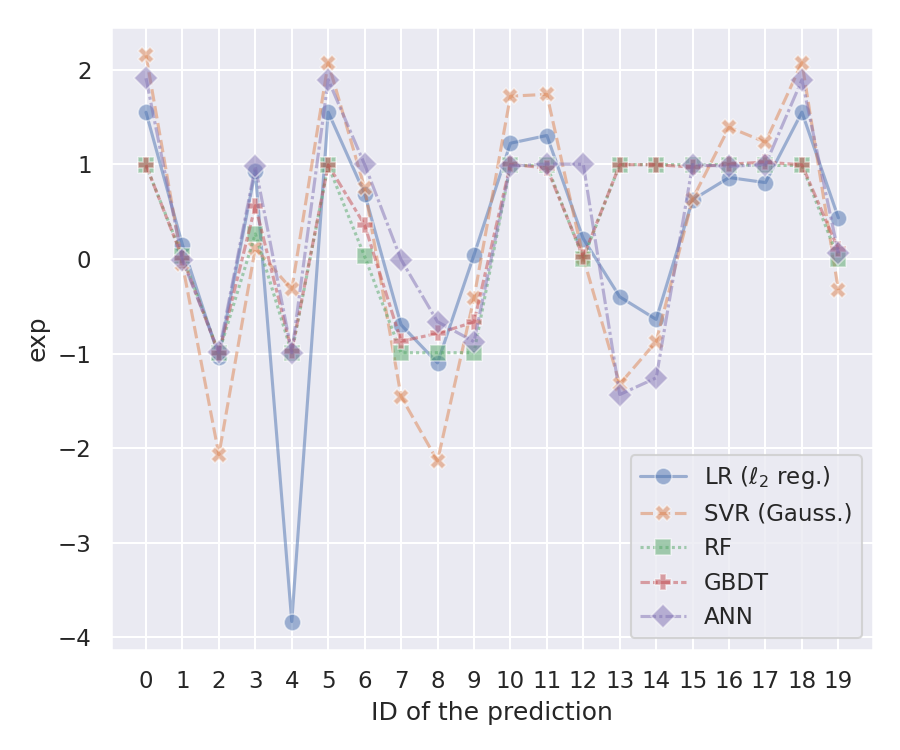

In [12]:
from IPython.display import Image
Image('./img/dlumps_pred.png', width=480)

## Comparing the Results

We finally compare the results with the extrapolations:

In [39]:
import pandas as pd

dlumps_exp = pd.read_json('./data/dlumps_exp.json')
df         = pd.read_csv('./data/data_sft_dlump_preds_short.csv')

# merge the values
df = pd.merge(df, dlumps_exp, left_index=True, right_index=True)

We then select only the low weights:

In [40]:
df_low = df.loc[df['weight'] < 1.5]
df_low = df_low.drop(columns=['weight', 'type'])

We then compute the metrics:

In [41]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

pred = df_low.filter(regex='^exp_')
true = df_low['exp']
met  = pd.DataFrame(index=['LR', 'r-SVR', 'RF', 'GBDT', 'ANN'])

# compute the metrics
met['MSE'] = [mean_squared_error(true.values.reshape(-1,),
                                 pred[feat].values.reshape(-1,)
                                )
              for feat in pred
             ]
met['MAE'] = [mean_absolute_error(true.values.reshape(-1,),
                                  pred[feat].values.reshape(-1,)
                                 )
              for feat in pred
             ]

met['R2'] = [r2_score(true.values.reshape(-1,),
                      pred[feat].values.reshape(-1,)
                     )
              for feat in pred
             ]

# print the metrics
met

,MSE,MAE,R2
LR,0.335605,0.502808,0.849034
r-SVR,0.097146,0.249551,0.956301
RF,0.626431,0.680042,0.718212
GBDT,0.623042,0.675549,0.719736
ANN,0.431317,0.449995,0.805980
